# 🐘 High-Performance PostgreSQL with Python

This notebook isn't just a syntax guide—it's a performance benchmark and data engineering lab.

### What we are building:
1. **In-Notebook Database**: We will install and boot a live Postgres server here.
2. **The Speed Test**: Comparing `INSERT` vs `COPY` protocols.
3. **Hybrid Modeling**: Combining rigid SQL schemas with flexible `JSONB` NoSQL fields.
4. **Visual Analytics**: Querying the DB and plotting results immediately.

In [1]:
# 1. Setup the Database Environment (Fixes Connection Refused)
!apt-get -y -qq update
!apt-get -y -qq install postgresql
!service postgresql start

# Setup a default user and database
!sudo -u postgres psql -c "CREATE USER lab_user WITH PASSWORD 'data_is_cool';"
!sudo -u postgres psql -c "CREATE DATABASE lab_db OWNER lab_user;"

# Install Python drivers and visualization tools
%pip install -q "psycopg[binary]" pandas seaborn matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Preconfiguring packages ...
Selecting previously unselected package logrotate.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package libcommon-sense-perl:amd64.
Preparing to unpack .../02-libcommon-sense-perl_3.75-2build1_amd64.deb ...
Unpacking libcommon-sense-perl:amd64 (3.75-2build1) ...
Selecting previously unselected package libjson-perl.
Preparing to unpack .../03-libjson-perl_4.04000-1_all.deb ...
Unpacking libjson-perl (4.04000-1) ...
Selecting previously unselected package libtypes-serialiser-perl

In [2]:
import psycopg
import json
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DB_CONFIG = {
    "host": "localhost",
    "dbname": "lab_db",
    "user": "lab_user",
    "password": "data_is_cool",
    "port": 5432
}

def get_conn():
    return psycopg.connect(**DB_CONFIG)

print("✅ Database is live and Python is connected!")

✅ Database is live and Python is connected!


## 2. The Stress Test: `INSERT` vs `COPY`

In data engineering, performance is a feature. Let's create a table and see why the `COPY` protocol is the king of speed.



In [3]:
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS benchmarks;")
        cur.execute("CREATE TABLE benchmarks (id SERIAL, val TEXT);")
        conn.commit()

data_volume = 10000
sample_data = [(f"value_{i}",) for i in range(data_volume)]

# Test 1: Standard Execution
start = time.time()
with get_conn() as conn:
    with conn.cursor() as cur:
        for row in sample_data:
            cur.execute("INSERT INTO benchmarks (val) VALUES (%s)", row)
    conn.commit()
insert_time = time.time() - start

# Test 2: COPY Protocol
start = time.time()
with get_conn() as conn:
    with conn.cursor() as cur:
        with cur.copy("COPY benchmarks (val) FROM STDIN") as copy:
            for row in sample_data:
                copy.write_row(row)
    conn.commit()
copy_time = time.time() - start

print(f"🚀 Insert time: {insert_time:.2f}s")
print(f"🔥 COPY time: {copy_time:.2f}s")
print(f"Improvement: {insert_time/copy_time:.1f}x faster!")

🚀 Insert time: 1.89s
🔥 COPY time: 0.08s
Improvement: 24.3x faster!


## 3. Hybrid Data Modeling (Relational + JSONB)

We'll build a telemetry system where core data (Device ID) is strictly typed, but sensor data (JSON) is flexible.

In [4]:
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("CREATE TABLE IF NOT EXISTS sensor_logs (id SERIAL, device_id TEXT, payload JSONB);")

        logs = [
            ("A1", json.dumps({"temp": 22.5, "humidity": 45})),
            ("A1", json.dumps({"temp": 23.1, "humidity": 46})),
            ("B1", json.dumps({"temp": 19.0, "vibration": "low"})), # Dynamic schema!
            ("A1", json.dumps({"temp": 24.5, "humidity": 44}))
        ]

        cur.executemany("INSERT INTO sensor_logs (device_id, payload) VALUES (%s, %s)", logs)
        conn.commit()
print("Hybrid data loaded.")

Hybrid data loaded.


## 4. Visualizing SQL Insights

Let's extract nested JSON data and plot the temperature trends for Device A1.

/tmp/ipython-input-3480674974.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


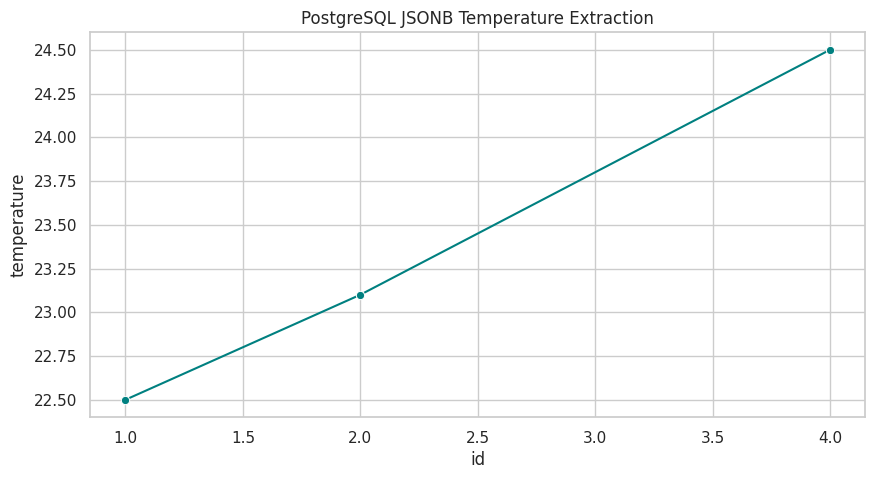

In [5]:
query = """
SELECT
    id,
    (payload->>'temp')::float as temperature
FROM sensor_logs
WHERE device_id = 'A1';
"""

with get_conn() as conn:
    df = pd.read_sql(query, conn)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='id', y='temperature', marker='o', color='teal')
plt.title("PostgreSQL JSONB Temperature Extraction")
plt.show()